# Bayes

In [22]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import matplotlib.pyplot as plt
import warnings 

plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')

import pymc3 as pm
import arviz as az
import theano.tensor as tt
pm.__version__

'3.9.3'

# Challenger

The Bayesian approach is simply another way to estimate the same models. For example, let's try to estimate logistic regression. 

On January $28$, $1986$, the space shuttle Challenger exploded on takeoff. Seven astronauts on board were dead. During the investigation into the cause of the crash, the main theory was a malfunction with the rubber o-rings in the rocket booster connection. For the $23$ preceding the Challenger flight disaster, the air temperature and the appearance of damage to at least one of the o-rings are known.

In [29]:
df = pd.read_csv('challenger.csv', sep=',')
print(df.shape)
df.head()

(23, 3)


,Date,Temperature,Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,01/11/1982,68,0
4,04/04/1983,67,0


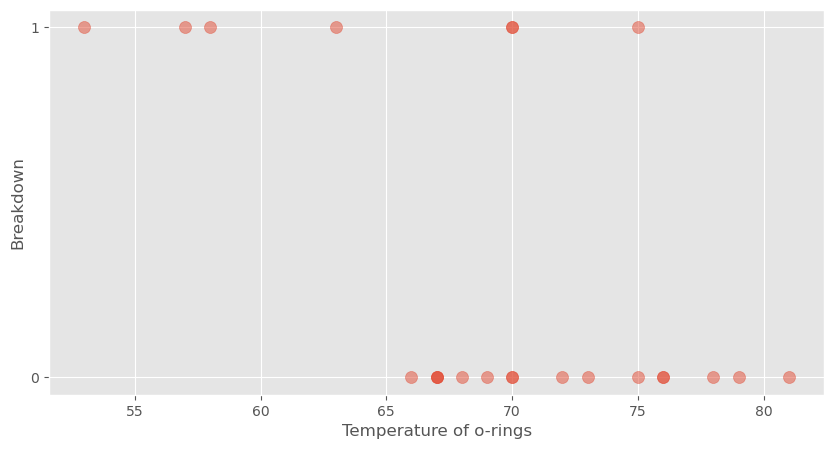

In [30]:
t = df.Temperature.values
y = df.Incident.values

plt.figure(figsize=(10, 5))
plt.scatter(t, y, s=75, alpha=0.5)
plt.yticks([0, 1])

plt.ylabel("Breakdown")
plt.xlabel("Temperature of o-rings");


Let's train the Bayesian version of the logistic regression.  The model will look as follows:

\begin{equation*}
\begin{aligned}
& \beta \sim N(0, 10^2) \\
& \alpha \sim N(0, 10^2) \\
& p \sim Bern(p) \\
& p = P(y = 1) = \frac{1}{1 + e^{\alpha + \beta \cdot t}}
\end{aligned}
\end{equation*}

In [6]:
t = df.Temperature.values
y = df.Incident.values

with pm.Model() as model:
    
    beta = pm.Normal("beta", mu=0, sigma=10)
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*t + alpha)))
    y_obs = pm.Bernoulli('y_obs', p, observed=y)

In [7]:
map_estimate = pm.find_MAP(model=model)

In [8]:
map_estimate

{'beta': array(0.16651426),
 'alpha': array(-10.55271034),
 'p': array([0.39240099, 0.24912435, 0.28155251, 0.316423  , 0.35348733,
        0.19211642, 0.16758636, 0.24912435, 0.74295751, 0.51557294,
        0.24912435, 0.08051265, 0.35348733, 0.84908654, 0.35348733,
        0.12610347, 0.24912435, 0.05045291, 0.10886635, 0.06901519,
        0.12610347, 0.10886635, 0.70989687])}

In [9]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=map_estimate)
    burned_trace = trace[100000::10]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 4 chains for 1_000 tune and 120_000 draw iterations (4_000 + 480_000 draws total) took 61 seconds.
The number of effective samples is smaller than 10% for some parameters.


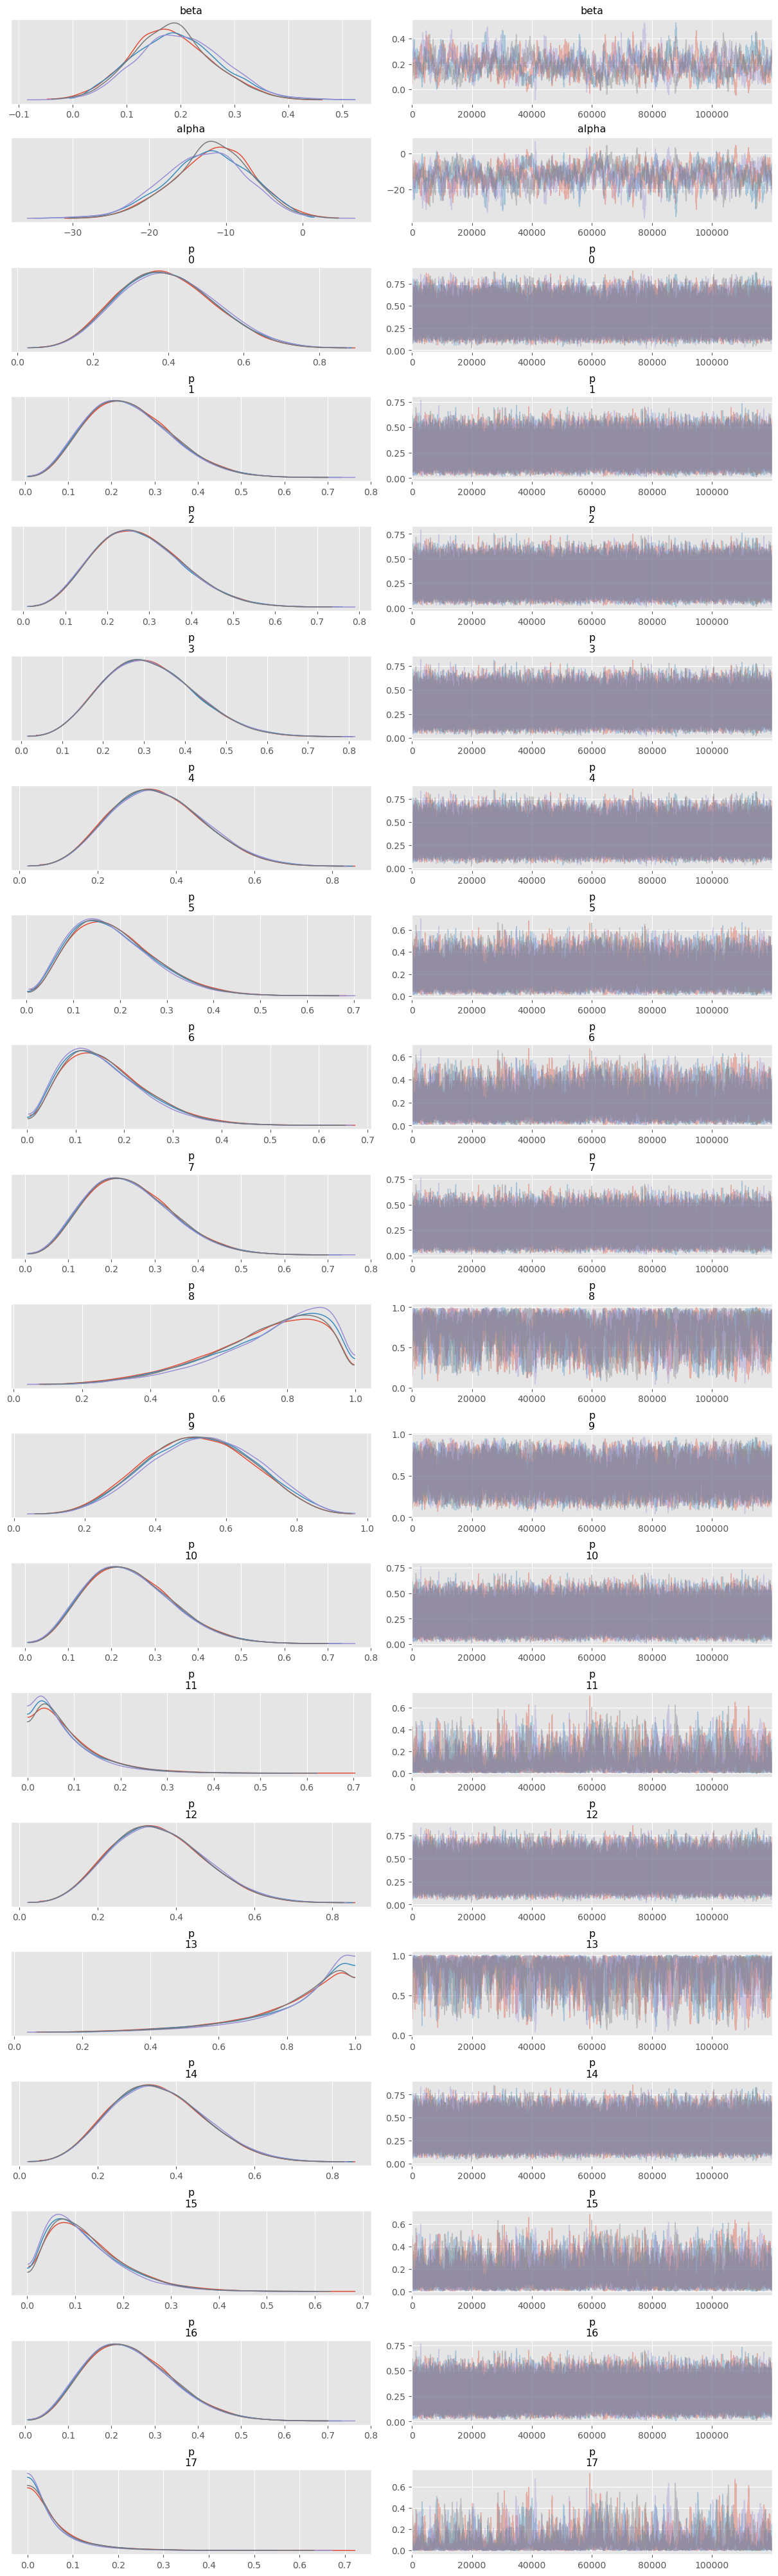

In [10]:
import arviz as az
az.plot_trace(trace);

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,0.191,0.078,0.050,0.342,0.004,0.003,323.0,323.0,317.0,1033.0,1.01
alpha,-12.158,5.339,-22.349,-2.444,0.297,0.210,323.0,323.0,318.0,1018.0,1.01
p[0],0.397,0.126,0.170,0.634,0.002,0.001,5010.0,4622.0,5324.0,13204.0,1.00
p[1],0.244,0.098,0.072,0.429,0.001,0.001,6837.0,6837.0,6070.0,17975.0,1.00
p[2],0.278,0.104,0.093,0.473,0.000,0.000,43307.0,43307.0,34394.0,46446.0,1.00
p[3],0.315,0.110,0.115,0.520,0.000,0.000,165533.0,165533.0,164336.0,146247.0,1.00
p[4],0.355,0.118,0.139,0.572,0.001,0.001,26104.0,19730.0,30385.0,34330.0,1.00
p[5],0.186,0.089,0.036,0.351,0.002,0.002,1555.0,1555.0,1463.0,6580.0,1.00
p[6],0.163,0.086,0.025,0.321,0.003,0.002,1094.0,1094.0,1040.0,4853.0,1.00
p[7],0.244,0.098,0.072,0.429,0.001,0.001,6837.0,6837.0,6070.0,17975.0,1.00


Let's look at the probability that $\beta < 0.0001$? So, we will look at the probability that there is no relationship between temperature and the probability of breakdown.

In [12]:
prob_beta = np.mean(trace['beta'] < 0.0001)
print(prob_beta)

0.0035041666666666667


As you can see, the probability is very small. So there is a strong relationshib between probabpblity of breakdown and temperature.

Let us draw the obtained results. For each temperature, find the $95\%$ Bayesian interval for the probability that a catastrophe will occur.

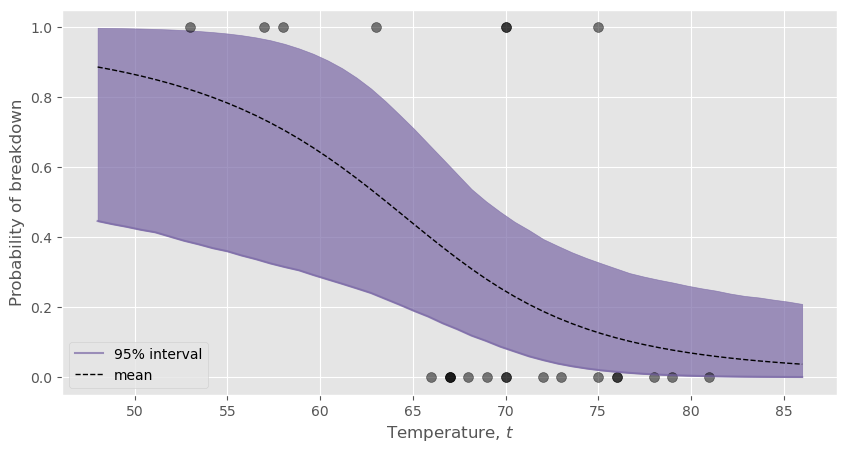

In [26]:
from scipy.stats.mstats import mquantiles

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t_seq = np.linspace(t.min() - 5, t.max()+5, 50)[:, None]
p_seq = logistic(t_seq.T, burned_trace['beta'][:,None], burned_trace['alpha'][:,None])

mean_prob_t = p_seq.mean(axis=0)
qs = mquantiles(p_seq, [0.025, 0.975], axis=0)

plt.figure(figsize=(10,5))
plt.fill_between(t_seq[:, 0], *qs, alpha=0.7, color="#7A68A6")
plt.plot(t_seq[:, 0], qs[0], label="95% interval", color="#7A68A6", alpha=0.7)
plt.plot(t_seq, mean_prob_t, lw=1, ls="--", color="k", label="mean")
plt.legend(loc="lower left")
plt.scatter(t, y, color="k", s=50, alpha=0.5)

plt.xlabel("Temperature, $t$")
plt.ylabel("Probability of breakdown");

On the day of the catastrophe, the temperature of the compactor was $31$ degrees Fahringheit. Let's find the posterior distribution of the probability of the catastrophe.

In [27]:
prob_31 = logistic(31, burned_trace['beta'][:,None], burned_trace['alpha'][:,None])

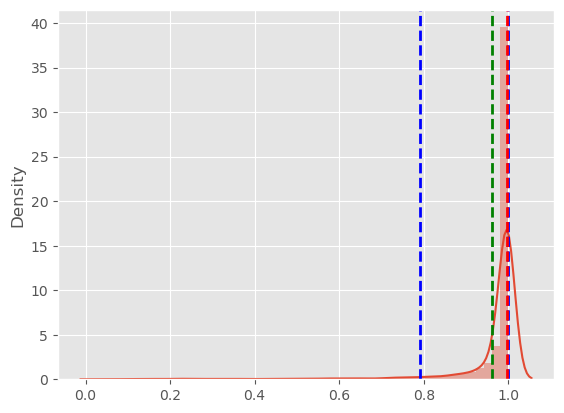

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(prob_31)
plt.axvline(np.quantile(prob_31, 0.95), color='b', linestyle="--", lw=2)
plt.axvline(np.quantile(prob_31, 0.05), color='b', linestyle="--", lw=2)
plt.axvline(np.mean(prob_31), color='g', linestyle="--", lw=2)
plt.axvline(np.median(prob_31), color='r', linestyle="--", lw=2);